# Importation des packages

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns
import pickle


# Importation des donn√©es

Ajoutez un raccourci de ce dossier √† votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [58]:
#Ce code permet de faire fonctionner tout le fichier dans VSCode et dans Google Collab sans avoir besoin de changer le code
def check_and_mount_drive():
    error = False
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        error = True
    return error

error_detected = check_and_mount_drive()


Mounted at /content/drive


# Importation des biblioth√®que

In [33]:
from time import time

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
#from drive.MyDrive.RNN_sentiment_dataset.random_tweets import *

# TF IDF Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csc_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# CNN Imports
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dense, Dropout, Flatten, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import random


In [64]:
if error_detected == True:
    file_path = "C:/Users/titou/OneDrive/Documents/ISEN/4 eme ann√©e/NLP/Projet/data_classification_commentaires_toxiques/train.csv"
else:
    file_path = "/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv"
randomnumber = random.randint(0, 1000000)
print (randomnumber) #Prend un nombre al√©atoire pour la selection des donn√©es
data = pd.read_csv(file_path).sample(n=100000, random_state=randomnumber) #On prend 100000 donn√©es al√©atoires
data.head()

529087


id                                       comment_text  \
120631  8549ab7c6a364d6f  The only thing you sons of biches can do. FUCK...   
90514   f2369ef949d3e363  Expansion\nTamogami has also said in interview...   
67372   b443598e448e56b2  See the following:\nPolicy on neutral point of...   
12785   21e7c79d49c5f06b  "\n\nWashington sister cities\nI put sources I...   
9610    197702d8e13970d7                         wikibofh reverted 3 times.   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
120631      1             1        1       0       1              0  
90514       0             0        0       0       0              0  
67372       0             0        0       0       0              0  
12785       0             0        0       0       0              0  
9610        0             0        0       0       0              0

# Pr√©paration des donn√©es

In [ ]:
# T√©l√©charger les stopwords (si ce n'est pas d√©j√† fait)
nltk.download('stopwords')
nltk.download('punkt_tab')

# Fonction am√©lior√©e pour nettoyer les commentaires
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+|www.\S+', '', text)  # Enlever les URLs
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions (@user)
    text = re.sub(r'[^a-z\s]', '', text)  # Supprimer tout sauf les lettres et espaces
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer espaces inutiles
    return text

# Appliquer le nettoyage sur la colonne 'comment_text'
data['cleaned_comment_text'] = data['comment_text'].apply(clean_text)

# Tokenize the 'cleaned_comment_text' column
# This creates the 'tokenized_comment_text' column
from nltk.tokenize import word_tokenize
data['tokenized_comment_text'] = data['cleaned_comment_text'].apply(word_tokenize)

# Supprimer les stopwords
stop_words = set(stopwords.words('english'))
data['tokenized_comment_text'] = data['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Convertir le texte en s√©quences num√©riques
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_comment_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_comment_text'])

# Calculer la longueur maximale de commentaire pour le padding
max_length = int(data['cleaned_comment_text'].apply(lambda x: len(x.split())).median())
print(f"Longueur m√©diane des commentaires : {max_length}")

# Appliquer le padding sur les s√©quences pour qu'elles aient toutes la m√™me longueur
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Afficher les 5 premi√®res s√©quences pour voir le r√©sultat
print(padded_sequences[:5])

print("Exemple de texte AVANT nettoyage :")
print(data['comment_text'].iloc[0])

print("\nExemple de texte APR√àS nettoyage :")
print(data['cleaned_comment_text'].iloc[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Etude du jeu de donn√©es

Informations de base sur le dataset :
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 126780 to 119043
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      50000 non-null  object
 1   comment_text            50000 non-null  object
 2   toxic                   50000 non-null  int64 
 3   severe_toxic            50000 non-null  int64 
 4   obscene                 50000 non-null  int64 
 5   threat                  50000 non-null  int64 
 6   insult                  50000 non-null  int64 
 7   identity_hate           50000 non-null  int64 
 8   cleaned_comment_text    50000 non-null  object
 9   tokenized_comment_text  50000 non-null  object
dtypes: int64(6), object(4)
memory usage: 4.2+ MB
None

V√©rification des valeurs manquantes :
id                        0
comment_text              0
toxic                     0
severe_toxic              0
obscene              

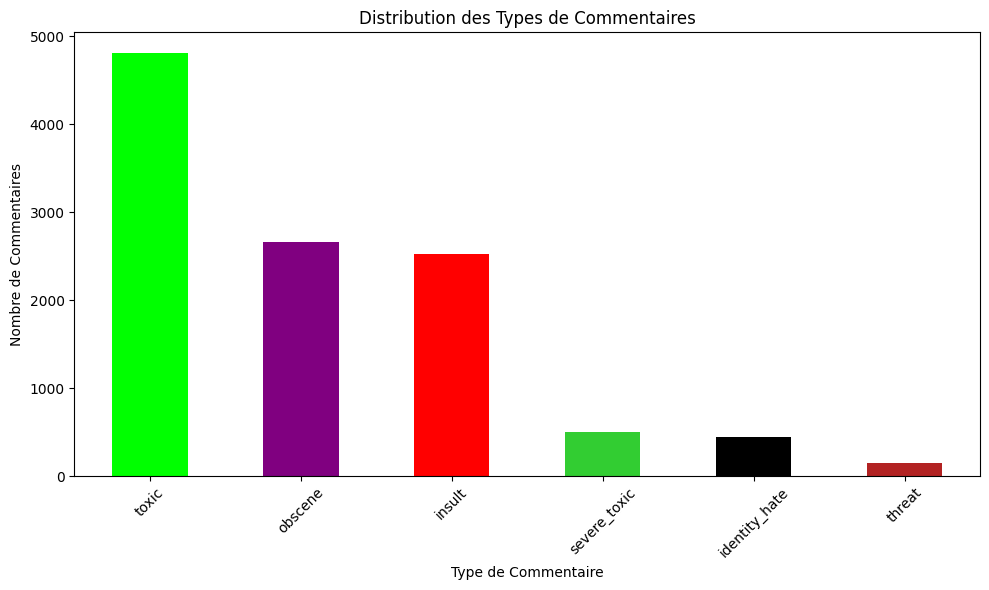

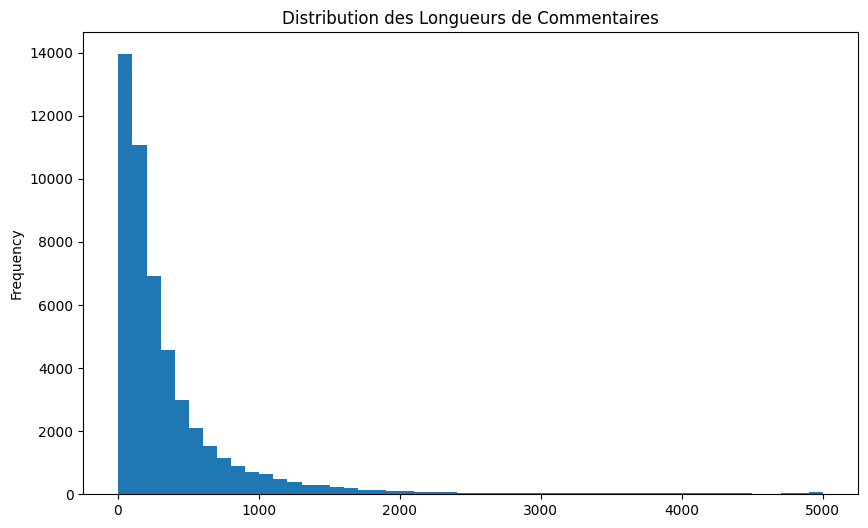

In [27]:
# Affichage des informations de base sur le dataset
print("Informations de base sur le dataset :")
print(data.info())

# V√©rification des valeurs manquantes
print("\nV√©rification des valeurs manquantes :")
print(data.isnull().sum())

# Supprimer les lignes o√π le commentaire est devenu vide apr√®s nettoyage
data = data[data['cleaned_comment_text'].str.strip() != '']
print(f"\nDonn√©es apr√®s suppression des commentaires vides : {data.shape}\n")


# Distribution des types de commentaires
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Liste des couleurs pour chaque type de commentaire
colors = ['#00FF00', '#800080', '#FF0000', '#32CD32', '#000000', '#B22222']

# Cr√©ation d'un graphique pour la distribution des types de commentaires avec des couleurs diff√©rentes
plt.figure(figsize=(10, 6))
data[target_columns].sum().sort_values(ascending=False).plot(kind='bar', color=colors)
plt.title('Distribution des Types de Commentaires')
plt.xlabel('Type de Commentaire')
plt.ylabel('Nombre de Commentaires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Affichage de la distribution des longueurs de commentaires
data['comment_length'] = data['comment_text'].apply(len)
data['comment_length'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution des Longueurs de Commentaires')
plt.show()

# Entra√Ænement du mod√®le baseline

##### A utilis√© beaucoup trop de ram, on va tester autre choses

In [ ]:
"""# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_columns))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))"""

'# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)\n\n# Initialize the RandomForestClassifier\nrf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Train the model\nrf_classifier.fit(X_train, y_train)\n\n# Make predictions on the test set\ny_pred = rf_classifier.predict(X_test)\n\n# Evaluate the model\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred, target_names=target_columns))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))\n\nprint("Accuracy Score:")\nprint(accuracy_score(y_test, y_pred))'

In [31]:
# Fonction pour traiter chaque chunk
def process_chunk(chunk, chunk_index):
    start_time = time()
    tweet_tokenizer = TweetTokenizer()  # D√©finir le tweet_tokenizer

    # Nettoyage du texte
    chunk['cleaned_comment_text'] = chunk['comment_text'].apply(clean_text)

    # Supprimer les commentaires vides apr√®s nettoyage (en maintenant les indices)
    chunk = chunk[chunk['cleaned_comment_text'].str.strip() != ""].reset_index(drop=True)

    # Tokenisation
    chunk['tokenized_comment_text'] = chunk['cleaned_comment_text'].apply(tweet_tokenizer.tokenize)

    # Suppression des stopwords
    chunk['tokenized_comment_text'] = chunk['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

    # Conversion en s√©quences de tokens
    sequences = tokenizer.texts_to_sequences(list(chunk['cleaned_comment_text']))  # Utilisation de `list()` pour acc√©l√©rer

    # Supprimer les lignes avec NaN dans les labels et r√©-aligner les indices
    chunk = chunk.dropna(subset=target_columns).reset_index(drop=True)

    # Padding
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # V√©rification du nombre de lignes apr√®s traitement et nettoyage
    print(f"‚úÖ Chunk {chunk_index} trait√© en {time() - start_time:.2f} sec - {len(chunk)} commentaires")
    print(f"‚úÖ Taille des s√©quences apr√®s padding: {padded_sequences.shape[0]}")

    return padded_sequences, chunk[target_columns].values

# Param√®tres de traitement en chunks
chunk_size = 10000
padded_sequences_list = []
y_list = []

# Lecture et traitement des donn√©es en chunks
for chunk_index, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, nrows=chunk_size * 5)):
    padded_sequences_chunk, y_chunk = process_chunk(chunk, chunk_index)
    padded_sequences_list.append(padded_sequences_chunk)
    y_list.append(y_chunk)

# Concat√©nation des r√©sultats finaux
padded_sequences = np.concatenate(padded_sequences_list, axis=0)
y = np.concatenate(y_list, axis=0)

# V√©rifier la taille des donn√©es
print("‚úÖ‚úÖ Traitement termin√© ! Nombre total de s√©quences:", padded_sequences.shape[0])
print("üìä Taille de padded_sequences:", padded_sequences.shape[0])
print("üìä Taille de y:", y.shape[0])

# V√©rification de la correspondance des tailles
assert padded_sequences.shape[0] == y.shape[0], "Les tailles de X et y ne correspondent pas !"

print("üîπ Exemple final de s√©quences apr√®s traitement:", padded_sequences[:5])
# Sauvegarder le tokenizer dans un fichier
with open('/content/drive/My Drive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

‚úÖ Chunk 0 trait√© en 5.42 sec - 9997 commentaires
‚úÖ Taille des s√©quences apr√®s padding: 9997
‚úÖ Chunk 1 trait√© en 5.44 sec - 9998 commentaires
‚úÖ Taille des s√©quences apr√®s padding: 9998
‚úÖ Chunk 2 trait√© en 4.52 sec - 10000 commentaires
‚úÖ Taille des s√©quences apr√®s padding: 10000
‚úÖ Chunk 3 trait√© en 6.31 sec - 10000 commentaires
‚úÖ Taille des s√©quences apr√®s padding: 10000
‚úÖ Chunk 4 trait√© en 4.58 sec - 9999 commentaires
‚úÖ Taille des s√©quences apr√®s padding: 9999
‚úÖ‚úÖ Traitement termin√© ! Nombre total de s√©quences: 49994
üìä Taille de padded_sequences: 49994
üìä Taille de y: 49994
üîπ Exemple final de s√©quences apr√®s traitement: [[15368   767    84   318    51  2160 10744    50  5896    15    61  2260
    145     7  2667    33   114  1092 12268  2938     4    45    53   234
      1   406    30     1    40    27   142    68  3733    88]
 [46948    57  2393    13  1453  3448    68  3845  2411    21    90    40
    969   183     0     0     0     0 

# It√©ration de la mod√©lisation

Epoch 1/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 72s 54ms/step - accuracy: 0.6186 - loss: 0.1437
Epoch 2/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 51ms/step - accuracy: 0.9189 - loss: 0.0559
Epoch 3/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 90s 58ms/step - accuracy: 0.9039 - loss: 0.0415
Epoch 4/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 54ms/step - accuracy: 0.8581 - loss: 0.0345
Epoch 5/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 52ms/step - accuracy: 0.6522 - loss: 0.0293
Epoch 6/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84s 54ms/step - accuracy: 0.6226 - loss: 0.0259
Epoch 7/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 55ms/step - accuracy: 0.5340 - loss: 0.0191
Epoch 8/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 51ms

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


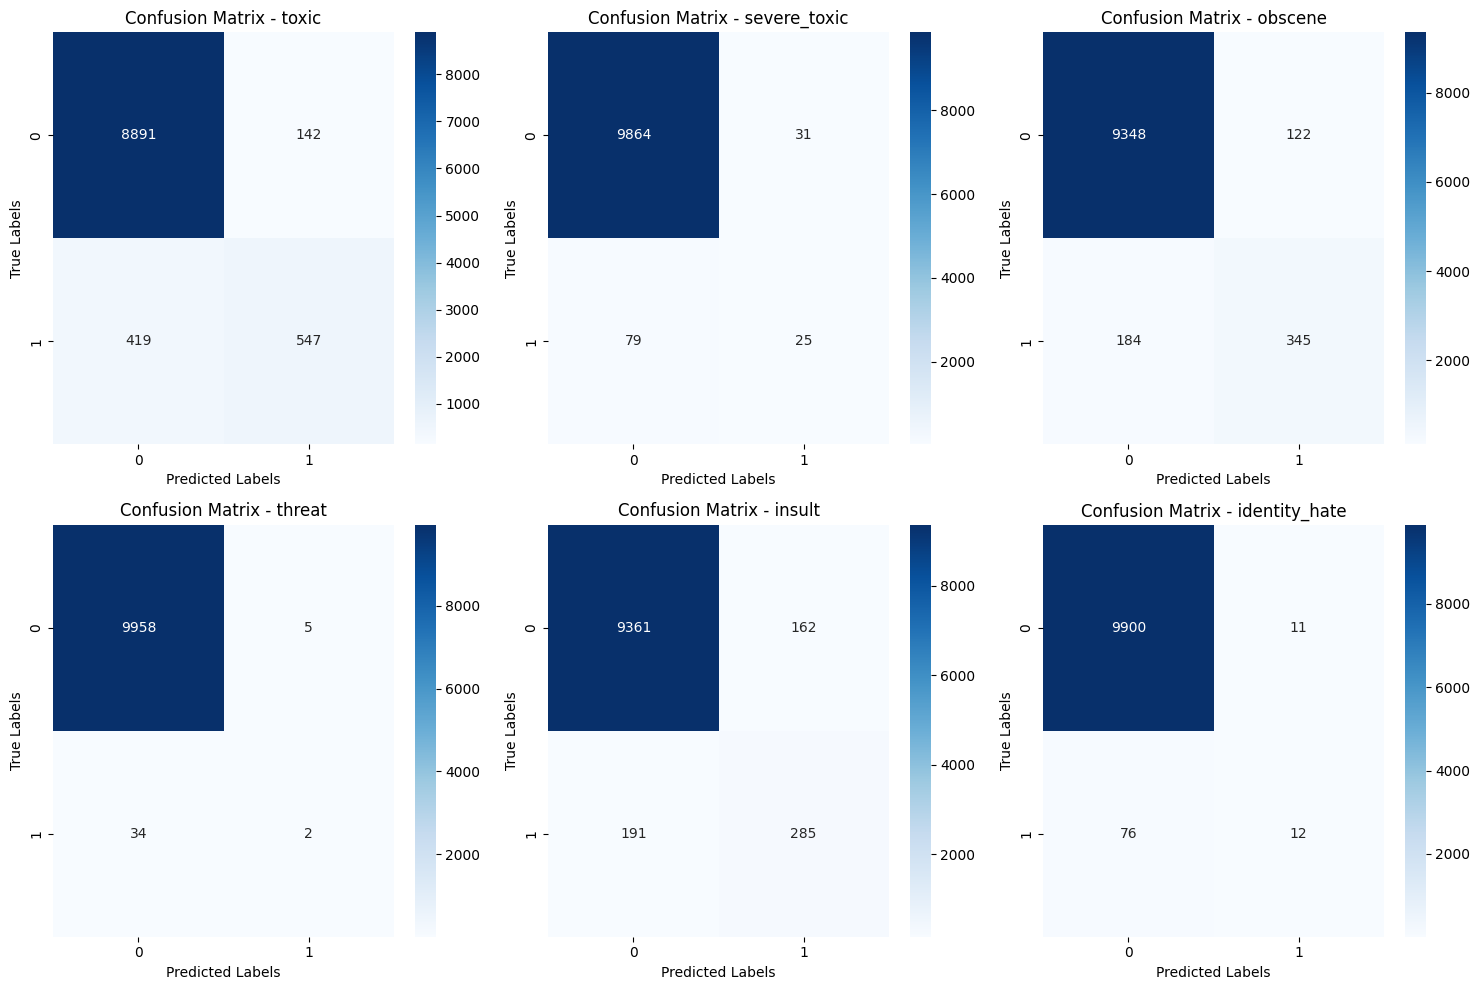

Accuracy Score with CNN:
0.9026902690269026
Le mod√®le a √©t√© sauvegard√© avec succ√®s sous le nom 'modele_entraine.h5'.


In [8]:
# Ajuster le Tokenizer sur ton ensemble de texte
tokenizer.fit_on_texts(data['cleaned_comment_text'])

# Obtenir la taille du vocabulaire
vocab_size = len(tokenizer.word_index) + 1  # Ajouter 1 car l'index commence √† 1

# D√©finition du mod√®le CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# D√©couper les donn√©es en ensembles d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Entra√Æner le mod√®le
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Faire des pr√©dictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les pr√©dictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Calculer l'accuracy pour chaque classe
accuracies_per_class = []

for i in range(y_test.shape[1]):  # Pour chaque colonne (chaque classe)
    acc = accuracy_score(y_test[:, i], y_pred_best_binary[:, i])
    accuracies_per_class.append(acc)

# Afficher les accuracies par classe
for i, class_name in enumerate(target_columns):
    print(f"Accuracy for {class_name}: {accuracies_per_class[i]:.4f}")

# Matrice de confusion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes
#axes = axes.ravel() # Remove this line to keep axes as a 2D array

# Boucle pour chaque colonne (chaque type de commentaire)
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de pr√©cision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))

# Enregistrement du mod√®le entra√Æn√© dans un fichier .h5
model.save('modele_entraine.h5')

# V√©rification de l'enregistrement
print("Le mod√®le a √©t√© sauvegard√© avec succ√®s sous le nom 'modele_entraine.h5'.")

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Enregistrer le mod√®le sur Google Drive
model.save('/content/drive/My Drive/mon_modele.h5')

# V√©rification
print("Le mod√®le a √©t√© sauvegard√© sur Google Drive sous le nom 'mon_modele.h5'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Le mod√®le a √©t√© sauvegard√© sur Google Drive sous le nom 'mon_modele.h5'.


In [66]:
# 1. Charger le mod√®le pr√©alablement entra√Æn√©
model = load_model('/content/drive/My Drive/mon_modele.h5')

# Recompiler le mod√®le pour s'assurer qu'il est pr√™t √† √™tre utilis√©
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Charger le tokenizer sauvegard√© lors de l'entra√Ænement
with open('/content/drive/My Drive/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
model.summary()

# D√©finir la longueur maximale des s√©quences (doit correspondre √† celle utilis√©e √† l'entra√Ænement)
MAXLEN = 35

# Charger les noms des cat√©gories (les √©tiquettes de classification)
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Exemple de nettoyage du texte (doit √™tre coh√©rent avec ce qui a √©t√© fait avant l'entra√Ænement)
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+', '', text)  # Supprimer les liens URL
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Supprimer les hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Supprimer la ponctuation et les chiffres
    text = text.strip()  # Supprimer les espaces superflus
    return text

# 3. Fonction de classification
def classify_text(input_text):
    # Nettoyer le texte
    cleaned_text = clean_text(input_text)

    # Tokeniser le texte
    text_sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Appliquer le padding
    padded_text = pad_sequences(text_sequence, maxlen=MAXLEN, padding='post')
    padded_text = np.array(padded_text, dtype=np.int32)

    # V√©rification de la forme de l'entr√©e
    print("Shape de l'entr√©e apr√®s padding:", padded_text.shape)

    # Pr√©diction avec le mod√®le
    prediction = model.predict(padded_text)

    # Convertir la pr√©diction en binaire (0 ou 1) avec un seuil de 0.5
    prediction_binary = (prediction > 0.5).astype(int)

    # Associer les pr√©dictions aux labels des classes
    result = {target_columns[i]: 'Yes' if prediction_binary[0][i] == 1 else 'No' for i in range(len(target_columns))}

    return result

# 4. Exemple d'utilisation de la fonction
input_text = "The only thing you sons of biches can do. FUCK YOU.FUCK YOU. Now block me properly. I can sign up again and do all the stuff again. You call your self admins. Prove to me that one of my edits were Disruptions."

# Appeler la fonction de classification
result = classify_text(input_text)

# Afficher le r√©sultat
print("R√©sultat de la classification :")
for label, prediction in result.items():
    print(f"{label}: {prediction}")


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)                ‚îÇ (None, 35, 50)              ‚îÇ       5,174,900 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d (Conv1D)                      ‚îÇ (None, 33, 64)              ‚îÇ           9,664 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization                  ‚îÇ (None, 33, 64)              ‚îÇ             256 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d (MaxPooling1D)         ‚îÇ (None, 16, 64)              ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 16, 64)              ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)                    ‚îÇ (None, 1024)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ (None, 64)                  ‚îÇ          65,600 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (None, 64)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (None, 6)                   ‚îÇ             390 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 5,250,810 (20.03 MB)

 Trainable params: 5,250,682 (20.03 MB)

 Non-trainable params: 128 (512.00 B)

Shape de l'entr√©e apr√®s padding: (1, 35)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 634ms/step
R√©sultat de la classification :
toxic: No
severe_toxic: No
obscene: No
threat: No
insult: No
identity_hate: No
